In [21]:
import numpy as np
import torch
from torch import nn
from scipy.stats import norm

from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

import matplotlib.pyplot as plt
import warnings

from IPython.display import Image
from IPython.display import display

In [3]:
np.random.seed(0)
batch_size = 64

# Load Datasets
train_dataset = FashionMNIST(root="./data",
                             train=True, download=True, transform=ToTensor())
test_dataset = FashionMNIST(root="./data",
                            train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=False)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size, shuffle=False)

In [4]:
"""
   Implement a ResNet9 whose learning rate is to be optimized
   
"""
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResBlock, self).__init__()
        stride = 1
        if downsample:
            stride = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet9(nn.Module):
    def __init__(self, in_channels=1, outputs=10):
        super(ResNet9, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResBlock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            ResBlock(64, 128, downsample=True),
            ResBlock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            ResBlock(128, 256, downsample=True),
            ResBlock(256, 256, downsample=False)
        )

        self.layer4 = nn.Sequential(
            ResBlock(256, 512, downsample=True),
            ResBlock(512, 512, downsample=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = input.view(input.size(0), -1)
        input = self.fc(input)

        return input


In [5]:
def plot_gp(learning_rates, lr_eval):
    
    """
    Plot the observations, predicted mean, 95%-confidence interval, and acquisition function
    for Gaussian Process optimization.

    Arguments:
        learning_rates (array-like): Array of learning rates/ observations.
        lr_eval (array-like): Array of corresponding accuracy values.

    """
        
    test_inputs = np.linspace(lr_bounds[0], lr_bounds[1], 10000).reshape(-1, 1)
    mean, std = gp.predict(test_inputs, return_std=True)

    fig, ax1 = plt.subplots(figsize=(10, 3))

    observations = ax1.scatter(learning_rates, lr_eval, marker='o',
                               color='navy', label='Observations')
    pred_mean = ax1.plot(test_inputs, mean, color='navy',
                         linestyle='solid', label='Predicted Mean')
    confidence_interval = ax1.fill_between(test_inputs.flatten(),
                                           (mean - 1.96 * std).flatten(),
                                           (mean + 1.96 * std).flatten(),
                                           color='lightskyblue', alpha=0.4,
                                           label='95% Confidence Interval')

    ax2 = ax1.twinx()
    acq_func_eval = np.array([expected_improvement(x.reshape(1, -1), lr_eval)
                              for x in test_inputs])
    ax2.plot(test_inputs, acq_func_eval, color='red', linestyle='dashed',
             label='Acquisition Function')

    ymin = np.min(acq_func_eval)
    ymax = np.max(acq_func_eval)
    ax2.set_ylim(ymin, ymax)

    ax1.set_xlabel('Learning Rates')
    ax1.set_ylabel('Observations /\n Predicted Mean of Accuracy')
    ax2.set_ylabel('Expected Improvement')

    lines = [observations, *pred_mean, confidence_interval, *ax2.get_lines()]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.2, 1),
               borderaxespad=0.)

    plt.tight_layout()

In [6]:
criterion = nn.CrossEntropyLoss()

model = ResNet9()

kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel)

function_optimizations = 10 #
epochs = 1 # The NN is only trained for one epoch to reduce computational time.
lr_bounds = [0.0001, 0.01]

initial_params = 1
n_eval_points = 1000 

In [7]:
def update_gradients(dataloader, model, criterion, optimizer):
    
    """
    Perform a forward pass, compute loss, update gradients, and optimize the model parameters.

    Arguments:
        dataloader (torch.utils.data.DataLoader): Data loader providing the training data.
        model (torch.nn.Module): The neural network model.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer used for updating gradients.

    """
    for images, labels in dataloader:
        pred = model(images)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [8]:
def objective_function(dataloader, model):
    
    """
    Compute the accuracy of a model on a given dataset.

    Arguments:
        dataloader (torch.utils.data.DataLoader): Data loader providing the dataset.
        model (torch.nn.Module): The neural network model.

    Returns:
        float: The accuracy of the model on the dataset.
    """
    correct = sum((model(images).argmax(1) == labels).sum().item()
                  for images, labels in dataloader)
    accuracy = correct / len(dataloader.dataset)
    return accuracy

In [9]:
def optimization_step(model, epochs, x=0.001):
    """
    Update the gradients with the given learning rate for the given model.
    Compute the accuracy.

    Args:
        model (nn.Module): The model to optimize.
        epochs (int): The number of training epochs.
        x (float, optional): The learning rate for the optimizer. Defaults to 0.001.

    Returns:
        float: The accuracy achieved after the optimization step.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=x)
    for epoch in range(epochs):
        update_gradients(train_dataloader, model, criterion, optimizer)
        accuracy = objective_function(test_dataloader, model)
    return accuracy

In [10]:
def expected_improvement(X, lr_eval):
    
    """
    Calculate the expected improvement for the given input points.

    Arguments:
        X (numpy.ndarray): Input points for which to calculate the expected improvement.
        lr_eval (numpy.ndarray): Accuracy achieved with the learning rates.

    Returns:
        numpy.ndarray: The calculated expected improvement.
    """
    mean, std = gp.predict(X, return_std=True)
    std = np.maximum(std, 1e-12)
    z = (mean - np.max(lr_eval)) / std
    ei = (mean - np.max(lr_eval)) * norm.cdf(z) + std * norm.pdf(z)
    return ei

In [11]:
def find_next_point(learning_rates, lr_eval, expected_improvement):
    
    """
    Find the next learning rate and its corresponding acquisition value for optimization.

    Args:
        learning_rates (numpy.ndarray): Array of previous learning rates.
        lr_eval (numpy.ndarray): Array of evaluation results of learning rates.
        expected_improvement (function): Function to calculate expected improvement.

    Returns:
        Tuple[numpy.ndarray, float]: Next learning rate and its corresponding acquisition value.
    """
    best_acq_value = -np.inf
    eval_points = np.random.uniform(lr_bounds[0], lr_bounds[1],
                                    size=(n_eval_points, 1))
    acq = np.array([expected_improvement(x.reshape(1, -1), lr_eval)
                    for x in eval_points])
    max_index = np.argmax(acq)
    acq_max = acq[max_index]
    best_acq_value = np.max(acq)
    if acq_max >= best_acq_value:
        next_lr = eval_points[max_index]
        best_acq_value = acq_max
    else:
        next_lr = next_lr = learning_rates[np.argmax(lr_eval)]
    return next_lr, best_acq_value

In [12]:
def bayes_optimization(learning_rates, lr_eval):
    
    """
    Perform Bayesian optimization to find optimal learning rates.

    Args:
        learning_rates (numpy.ndarray): Array of initial learning rates.
        lr_eval (numpy.ndarray): Array of evaluation results of learning rates.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray, float]: Final learning rates, evaluation results, and best acquisition value.
    """
    for i in range(function_optimizations):
        next_lr, best_acq_value = find_next_point(learning_rates, lr_eval,
                                                  expected_improvement)
        next_eval = optimization_step(model=model, epochs=1, x=next_lr[0])
        learning_rates = np.vstack((learning_rates, next_lr))
        lr_eval = np.append(lr_eval, next_eval)
        gp.fit(learning_rates, lr_eval)
        print(f"Iteration {i+1}: Learning Rate: {next_lr[0]} \nExpected Improvement: {best_acq_value[0]}")
        plot_gp(learning_rates, lr_eval)
        plt.text(0.5, 1.1, f'Function Evaluation No. {i+1}', ha='center',
                 va='center', transform=plt.gca().transAxes)
        plt.savefig(f"bo_plot_{i}.pdf")
        plt.savefig(f"bo_plot_{i}.png")
        plt.close()
    return learning_rates, lr_eval, best_acq_value

In [13]:
# Compute an initial learning rate to initialize the Gaussian process.
learning_rates = np.random.uniform(lr_bounds[0], lr_bounds[1],
                                   size=(initial_params, 1))
lr_eval = np.array([optimization_step(model=model, epochs=epochs,
                                      x=x[0]) for x in learning_rates])
gp.fit(learning_rates, lr_eval)

print('Initialization value of the Learning Rate: ', learning_rates[0])

Initialization value of the Learning Rate:  [0.00553325]


In [14]:
warnings.filterwarnings("ignore")
learning_rates, lr_eval, best_acq_value = bayes_optimization(learning_rates,
                                                             lr_eval)

Iteration 1: Learning Rate: 0.00010540505248025698 
Expected Improvement: 0.0027848746639426653
Iteration 2: Learning Rate: 0.00010363670313943282 
Expected Improvement: 6.633434012547866e-06
Iteration 3: Learning Rate: 0.007188636816747414 
Expected Improvement: 0.1730135560546361
Iteration 4: Learning Rate: 0.00999931835548628 
Expected Improvement: 0.13555281762755644
Iteration 5: Learning Rate: 0.008788365211108227 
Expected Improvement: 0.10477335567069501
Iteration 6: Learning Rate: 0.006284829887202355 
Expected Improvement: 0.0287508568084332
Iteration 7: Learning Rate: 0.009410847597837326 
Expected Improvement: 0.012988032036053546
Iteration 8: Learning Rate: 0.008166491872116228 
Expected Improvement: 0.006848808835773034
Iteration 9: Learning Rate: 0.006060094252962724 
Expected Improvement: 0.0015075192969019686
Iteration 10: Learning Rate: 0.004171991287037374 
Expected Improvement: 0.017422156090214313


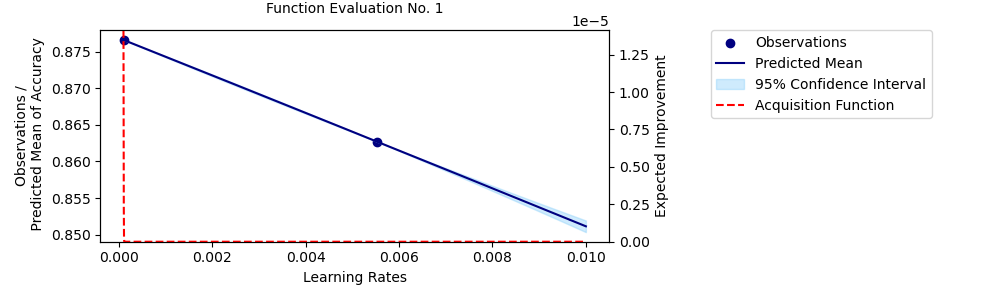

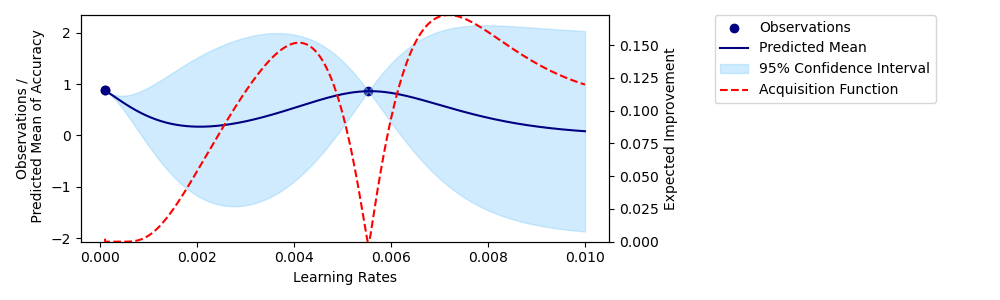

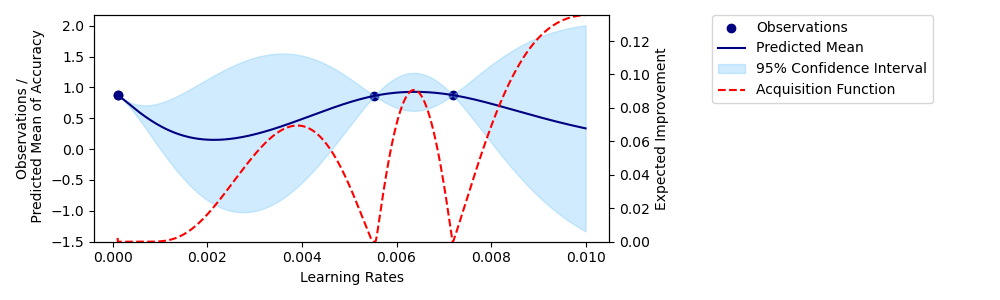

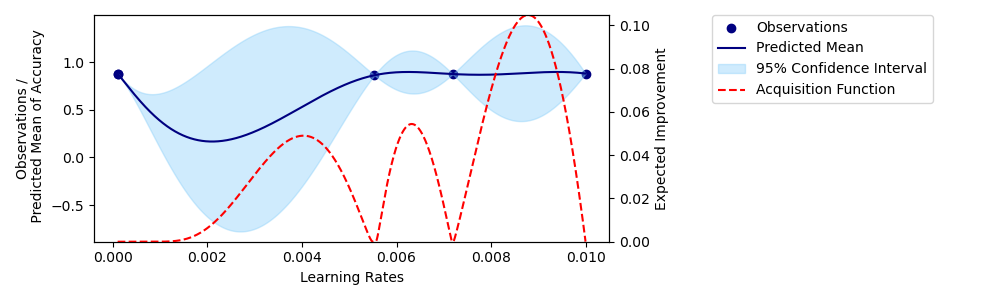

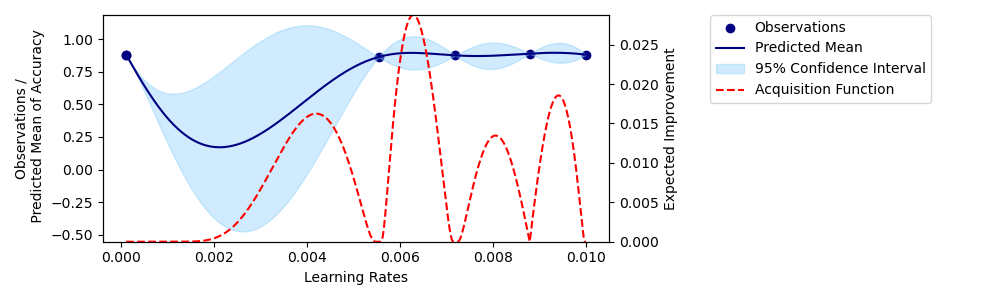

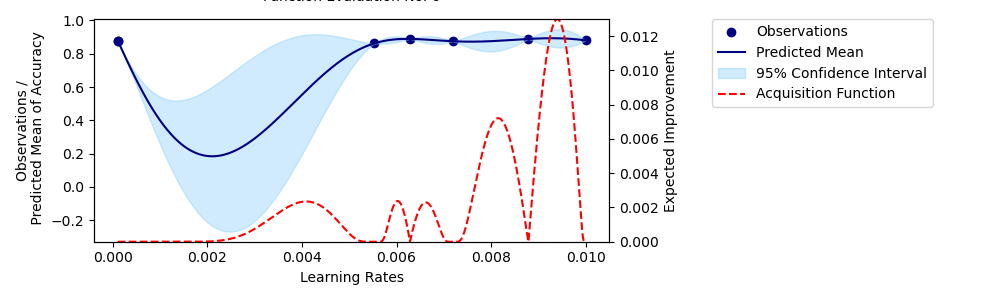

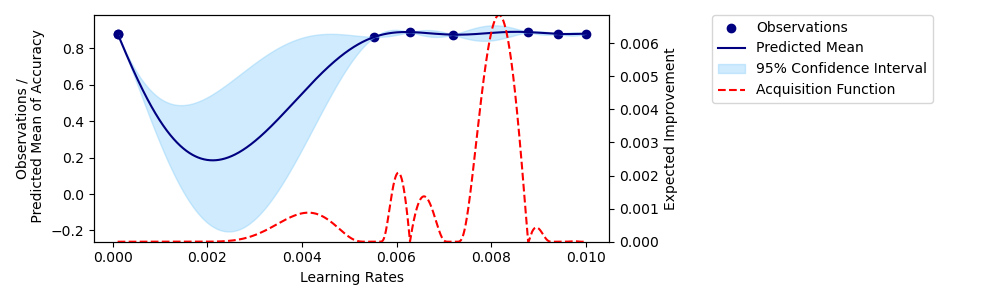

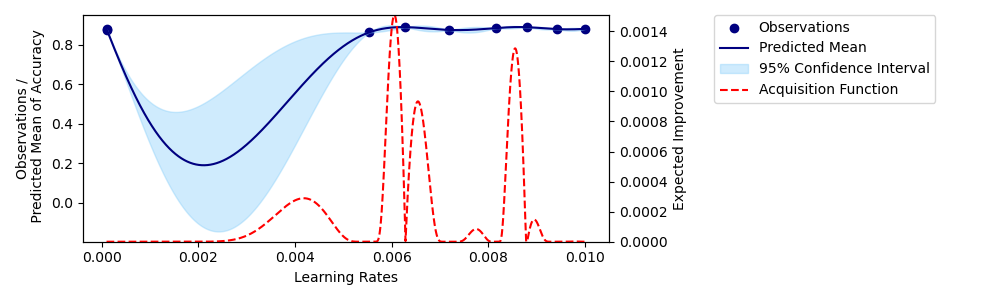

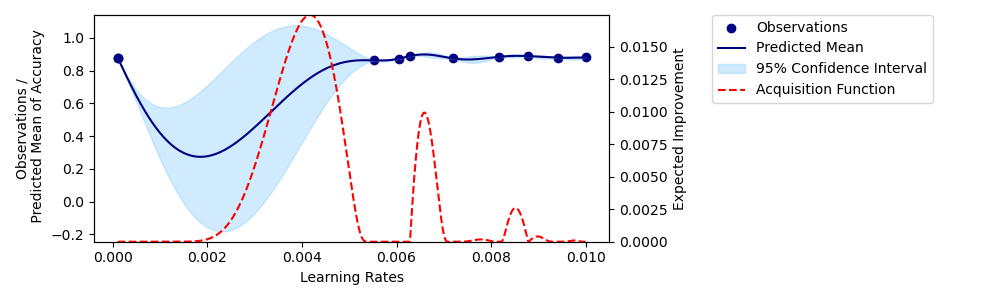

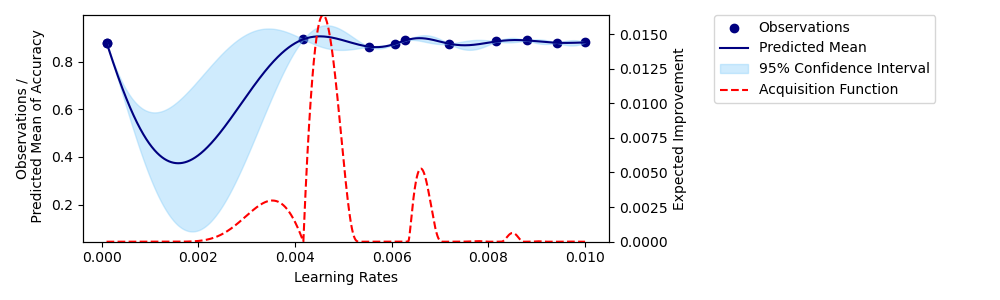

In [15]:
for i in range(function_optimizations):
    display(Image(filename=f'bo_plot_{i}.png'))